<a href="https://colab.research.google.com/github/salmanromeo/CS_5683_Big_Data_Analytics/blob/main/Assignment_3_Personalized_PageRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment**

For this assignment, we will use the MovieLens dataset from MovieLens 100K. We require 'user-id,' 'movie-id,' 'movie names,' 'movie-genre,' 'rating,' and 'rating timestamp' for this assignment. Students must write a program to randomly select 100 users and their last 5 ratings for evaluation. Importantly, this data must not be used to build your PageRank algorithm.

**Task**

1.   Create a tripartite graph of User - Movie - Genre structure as shown in the figure above. Students have total freedom to decide the strategy for storing and using this structure in their programs. For instance, the naïve approach might involve defining this structure as a directed or undirected network using the networkX package. However, this approach could consume more memory space for large datasets. Students can implement memory efficient approaches for additional points.
2.   Implement the Personalized PageRank (PPR) algorithm on the structure discussed above. Topic Specific PageRank becomes PPR when we set "topics" as "personalization factors". Each user in the dataset should have a personalization vector for this algorithm. Students should choose this personalization factor from user or movie or genre or any combinations thereof. Below are some tips for this task:
*   We discussed the PageRank algorithms in detail in our lectures. Students must develop the PPR algorithm for graphs that contain dead-ends and spider traps.
*   We do not want one algorithm for each user that could overwhelm our computers. We want one PageRank model to work for all users.
3.   Error calculation: Calculate the error for each iteration by summarizing changes in PPR values of all nodes using RMSE. Set the convergence threshold based on RMSE or the Provide a line graph plot for PPR convergence.
4.   Evaluation: Using the ranked nodes with PPR algorithm, write a program to extract the top 'k' movie recommendations for users in the evaluation data. We will evaluate these recommendations against actual relevant movies using Precision@k, Recall@k, and NDCG@k metrics. NOTE: Do not be alarmed if these metric values are low during evaluations; usually, the values will be very low. Increasing the value of 'k' will improve these results. However, higher 'k' values reduce the capability of the recommendation system.
*   Precision@k = No. of relevant items in top-k predictions/k
*   Recall@k = No. of relevant items in top-k predictions/No. of actual relevant items
*   NDCG@k is mainly used to factor the ranking in our recommendation predictions. Use this metric only when you give importance to the order of recommendations in your program results. Use https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html.

Typically, we analyze these values for each user in the test data. You can get an average of these values for all users.

**Task 1: Visualize a subset of the graph with node names**

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

# Load data
df_data = pd.read_csv("/content/sample_data/u.data", sep="\t", header=None, names=["user_id", "movie_id", "rating", "timestamp"])
df_item = pd.read_csv("/content/sample_data/u.item", sep="|", header=None, names=["movie_id", "movie_title", "release_date", "video_release_date", "imdb_url"] + [f"genre_{i}" for i in range(19)], encoding="ISO-8859-1")
df_genre = pd.read_csv("/content/sample_data/u.genre", sep="|", header=None, names=["genre_name", "genre_id"])

df_data.head(), df_item.head(), df_genre.head()

(   user_id  movie_id  rating  timestamp
 0      196       242       3  881250949
 1      186       302       3  891717742
 2       22       377       1  878887116
 3      244        51       2  880606923
 4      166       346       1  886397596,
    movie_id        movie_title release_date  video_release_date  \
 0         1   Toy Story (1995)  01-Jan-1995                 NaN   
 1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
 2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
 3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
 4         5     Copycat (1995)  01-Jan-1995                 NaN   
 
                                             imdb_url  genre_0  genre_1  \
 0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0        0   
 1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0        1   
 2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0        0   
 3  http://us.imdb.com/M/title-exact?Get%20

In [2]:
# Create the Graph
G = nx.Graph()

# Add nodes and edges for users, movies, and genres
for user_id in df_data["user_id"].unique():
    G.add_node(user_id, type="user")

for index, row in df_data.iterrows():
    movie_id = row["movie_id"]
    G.add_node(movie_id, type="movie")
    G.add_edge(row["user_id"], movie_id, weight=row["rating"])

for index, row in df_item.iterrows():
    for genre_col, genre_flag in row.filter(like="genre_").items():
        if genre_flag == 1:
            genre_id = int(genre_col.split("_")[1])
            genre_name = df_genre[df_genre["genre_id"] == genre_id]["genre_name"].values[0]
            G.add_node(genre_name, type="genre")
            G.add_edge(row["movie_id"], genre_name)

In [3]:
# Graph details
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
num_nodes, num_edges

(1701, 97821)

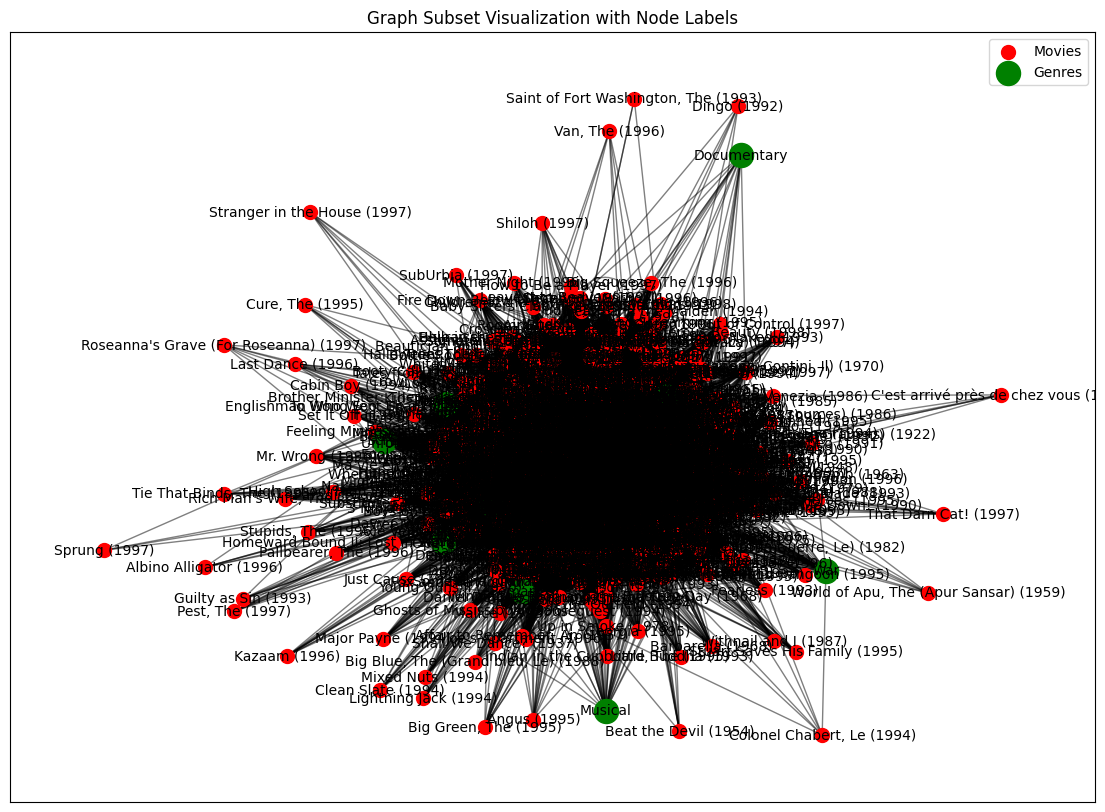

In [4]:
# Assign names to user nodes
for user_id in df_data["user_id"].unique():
    G.nodes[user_id]["name"] = f"User_{user_id}"

# Assign names to movie nodes
for _, row in df_item.iterrows():
    movie_id = row["movie_id"]
    G.nodes[movie_id]["name"] = row["movie_title"]

# Genre nodes retain their original names as their labels
for genre_name in df_genre["genre_name"]:
    if genre_name in G.nodes:
        G.nodes[genre_name]["name"] = genre_name

def plot_graph_subset_with_labels(G, movie_limit=10):
    """
    Draws a subset of the graph with labeled nodes, displaying user, movie, and genre nodes.
    """
    nodes_to_include = set()

    # Select a subset of movies and add associated nodes (users, genres)
    movie_nodes = [node for node, data in G.nodes(data=True) if data.get("type") == "movie"]
    for movie in movie_nodes[:movie_limit]:
        nodes_to_include.add(movie)
        neighbors = G.neighbors(movie)
        nodes_to_include.update(neighbors)

    # Create a subgraph containing only the selected nodes
    H = G.subgraph(nodes_to_include)

    # Determine node types for separate coloring
    user_nodes = [node for node, data in H.nodes(data=True) if data.get("type") == "user"]
    movie_nodes = [node for node, data in H.nodes(data=True) if data.get("type") == "movie"]
    genre_nodes = [node for node, data in H.nodes(data=True) if data.get("type") == "genre"]

    # Generate positions for the graph layout
    positions = nx.spring_layout(H)

    # Extract node names for labeling
    labels = {node: data["name"] for node, data in H.nodes(data=True)}

    # Plot the graph with custom colors and labels
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(H, positions, nodelist=user_nodes, node_color="blue", node_size=30, label="Users")
    nx.draw_networkx_nodes(H, positions, nodelist=movie_nodes, node_color="red", node_size=100, label="Movies")
    nx.draw_networkx_nodes(H, positions, nodelist=genre_nodes, node_color="green", node_size=300, label="Genres")
    nx.draw_networkx_labels(H, positions, labels=labels, font_size=10, font_color="black")
    nx.draw_networkx_edges(H, positions, alpha=0.5)
    plt.legend()
    plt.title("Graph Subset Visualization with Node Labels")
    plt.show()

# Call the visualization function for a subset of the graph
plot_graph_subset_with_labels(G, movie_limit=10)

**Task 2: Implement the Personalized PageRank (PPR) algorithm**

In [5]:
# Function to create a subgraph based on a subset of users and their rated movies/genres
def create_subgraph_with_networkx(G, users, df_data):
    """
    Construct a subgraph from a graph `G` based on a list of selected users.
    Includes users, their rated movies, and corresponding genres.

    Parameters:
        G (networkx.Graph): Original graph containing users, movies, and genres.
        users (list): List of user IDs to include in the subgraph.
        df_data (pd.DataFrame): Dataframe with user ratings, containing columns 'user_id' and 'movie_id'.

    Returns:
        networkx.Graph: A reduced subgraph of the original graph.
    """
    selected_nodes = set(users)  # Start with user nodes

    # Add movies rated by users and their associated genres
    for user in users:
        user_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
        selected_nodes.update(user_movies)

        for movie in user_movies:
            # Get the neighboring genres of each movie node
            genre_neighbors = [nbr for nbr, attr in G[movie].items() if G.nodes[nbr].get("type") == "genre"]
            selected_nodes.update(genre_neighbors)

    # Generate the subgraph with the selected nodes
    return G.subgraph(selected_nodes)

# Select a random sample of users and create a reduced subgraph
sampled_users = df_data["user_id"].sample(5).tolist()
H_reduced = create_subgraph_with_networkx(G, sampled_users, df_data)

# Function to calculate Personalized PageRank using NetworkX's built-in function
def compute_personalized_pagerank(G, users, df_data, alpha=0.85):
    """
    Compute Personalized PageRank (PPR) scores for a list of users using NetworkX's built-in PageRank function.

    Parameters:
        G (networkx.Graph): Graph (subgraph) with users, movies, and genres.
        users (list): List of user IDs for PPR calculation.
        df_data (pd.DataFrame): Dataframe with user ratings, containing columns 'user_id' and 'movie_id'.
        alpha (float): Damping factor for PageRank (default 0.85).

    Returns:
        dict: PPR results for each user with their personalized scores.
    """
    ppr_scores = {}

    for user in users:
        # Define the personalization vector for the user
        user_rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
        personalization = {node: 1 if node in user_rated_movies else 0 for node in G.nodes}

        # Normalize the personalization vector
        total = sum(personalization.values())
        if total > 0:
            personalization = {k: v / total for k, v in personalization.items()}

        # Calculate Personalized PageRank for the user
        ppr_scores[user] = nx.pagerank(G, alpha=alpha, personalization=personalization)

    return ppr_scores

# Calculate PPR scores using NetworkX's built-in function
ppr_results = compute_personalized_pagerank(H_reduced, sampled_users, df_data, alpha=0.85)

# Display PPR results
ppr_results

{325: {1: 0.0057114042445876,
  2: 0.002114618229910629,
  3: 0.0006465620512262047,
  4: 0.0013912774151451052,
  7: 0.005157351358044822,
  8: 0.002086856332182378,
  'Adventure': 0.00034830720597668375,
  10: 0.00279549507204462,
  11: 0.0027330632672162786,
  12: 0.0025429601051101484,
  13: 0.0045764606802555004,
  14: 0.0022228458096586814,
  15: 0.002232939528995056,
  16: 0.003115923405290109,
  17: 0.0006844780216027056,
  9: 0.002200416372528427,
  19: 0.0006411634120710891,
  22: 0.003070115591450346,
  23: 0.0038019747926820694,
  24: 0.0015963464196850055,
  25: 0.002425775715417931,
  27: 0.0004907959074896756,
  28: 0.0033989666698709844,
  31: 0.0012271318091692366,
  32: 0.0020978062556841733,
  38: 0.0015905076199695712,
  40: 0.0005043223659530698,
  42: 0.0025254899669149293,
  43: 0.002164660071664929,
  45: 0.0008900211143278464,
  46: 0.0004755281275870874,
  47: 0.0020554959672491194,
  48: 0.001735092922102219,
  49: 0.001878936947164963,
  50: 0.00543371894428

**Task 3: Implement Personalized PageRank (PPR) with RMSE tracking**

Converged after 9 iterations with RMSE: 0.000001


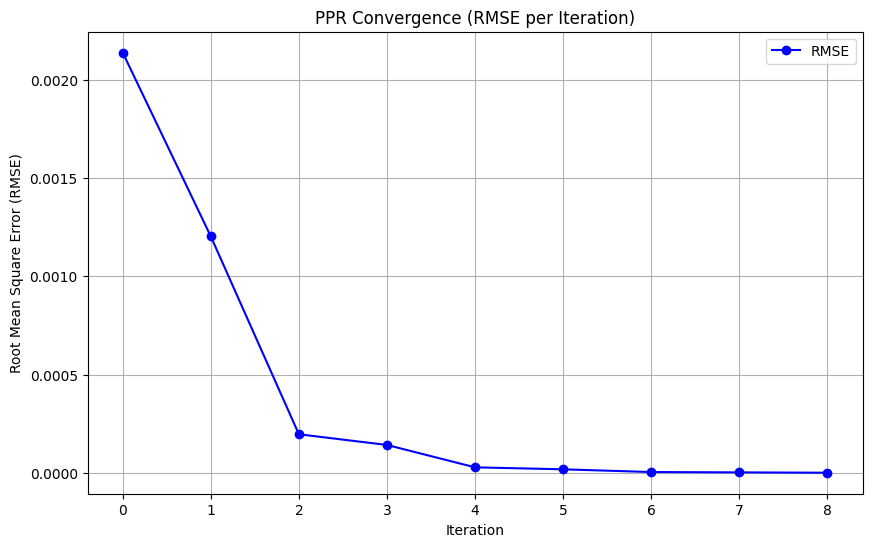

In [7]:
# Implement Personalized PageRank (PPR) with RMSE tracking
def personalized_page_rank_with_rmse(G, personalization, alpha=0.85, max_iter=100, tol=1.0e-6):
    """
    Compute Personalized PageRank with RMSE tracking to monitor convergence.

    Parameters:
        G (networkx.Graph): Input graph with nodes (users, movies, genres).
        personalization (dict): Personalization vector with node IDs as keys and initial values as preferences.
        alpha (float): Damping factor for PPR, typically set to 0.85.
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance based on RMSE values.

    Returns:
        tuple: A dictionary of PPR scores and a list of RMSE values over iterations.
    """
    # Normalize the personalization vector
    s = sum(personalization.values())
    personalization = {k: v / s for k, v in personalization.items()}

    # Initialize PPR values equally across all nodes
    ppr = {node: 1 / len(G) for node in G}
    rmse_values = []

    # Iterative process to compute PPR with RMSE tracking
    for _ in range(max_iter):
        prev_ppr = ppr.copy()
        for node in G:
            local_sum = sum([(prev_ppr[neighbor] / len(list(G[neighbor]))) for neighbor in G.neighbors(node)])
            ppr[node] = (1 - alpha) * personalization.get(node, 0) + alpha * local_sum

        # Calculate RMSE for convergence check
        diff = np.array(list(ppr.values())) - np.array(list(prev_ppr.values()))
        rmse = np.sqrt(np.mean(diff ** 2))
        rmse_values.append(rmse)

        # Check convergence based on RMSE
        if rmse < tol:
            print(f"Converged after {_+1} iterations with RMSE: {rmse:.6f}")
            break

    return ppr, rmse_values

# Example Usage: Performing PPR for a single user and plotting RMSE values
user_id = df_data["user_id"].sample(1).iloc[0]
last_5_ratings = df_data[df_data["user_id"] == user_id].sort_values("timestamp").tail(5)

# Define personalization vector based on last 5 rated movies
personalization_vector = {node: 1 if node in last_5_ratings["movie_id"].values else 0 for node in G}

# Run PPR with RMSE tracking
ppr_scores, rmse_values = personalized_page_rank_with_rmse(G, personalization_vector)

# Plotting RMSE Values for Convergence
plt.figure(figsize=(10, 6))
plt.plot(rmse_values, marker='o', color='b', linestyle='-', label="RMSE")
plt.xlabel("Iteration")
plt.ylabel("Root Mean Square Error (RMSE)")
plt.title("PPR Convergence (RMSE per Iteration)")
plt.grid(True)
plt.legend()
plt.show()

**Task 4: Extract the top 'k' movie recommendations for users in the evaluation data**

In [9]:
from sklearn.metrics import precision_score, recall_score, ndcg_score

def precision_at_k(recommended, relevant, k):
    """
    Compute Precision@k using built-in precision_score from scikit-learn.

    Parameters:
    - recommended: list
        List of recommended items.
    - relevant: list
        List of relevant items.
    - k: int
        Number of top recommendations to consider.

    Returns:
    - Precision@k value.
    """
    recommended_k = recommended[:k]
    return precision_score([1 if item in relevant else 0 for item in recommended_k], [1] * len(recommended_k), average='binary')

def recall_at_k(recommended, relevant, k):
    """
    Compute Recall@k using built-in recall_score from scikit-learn.

    Parameters:
    - recommended: list
        List of recommended items.
    - relevant: list
        List of relevant items.
    - k: int
        Number of top recommendations to consider.

    Returns:
    - Recall@k value.
    """
    recommended_k = recommended[:k]
    return recall_score([1 if item in relevant else 0 for item in recommended_k], [1] * len(recommended_k), average='binary')

def ndcg_at_k(recommended, relevant, k):
    """
    Compute NDCG@k using scikit-learn's built-in ndcg_score.

    Parameters:
    - recommended: list
        List of recommended items.
    - relevant: list
        List of relevant items.
    - k: int
        Number of top recommendations to consider.

    Returns:
    - NDCG@k value.
    """
    recommended_k = recommended[:k]
    y_true = np.array([1 if item in relevant else 0 for item in recommended_k])
    y_score = np.array([1 for _ in recommended_k])  # Assuming all recommended items are equally ranked
    return ndcg_score([y_true], [y_score], k=k)

def get_top_k_recommendations(ppr, k):
    """
    Get top-k movie recommendations based on PPR values.

    Parameters:
    - ppr: dict
        Dictionary of nodes with their personalized page rank as value.
    - k: int
        Number of recommendations.

    Returns:
    - List of top-k movie recommendations.
    """
    # Filter out movies from the ppr dict and sort by PPR value
    sorted_movies = sorted([(node, value) for node, value in ppr.items() if G.nodes[node]['type'] == 'movie'],
                           key=lambda x: x[1], reverse=True)
    return [movie[0] for movie in sorted_movies[:k]]

# Test functions
recommended = [1, 3, 5, 7, 9]
relevant = [1, 2, 4, 6, 8]
k = 5
precision_test = precision_at_k(recommended, relevant, k)
recall_test = recall_at_k(recommended, relevant, k)
ndcg_test = ndcg_at_k(recommended, relevant, k)

precision_test, recall_test, ndcg_test

(0.2, 1.0, 0.5896918237758784)

In [10]:
# Generate recommendations and evaluate
k = 10
evaluation_results = {}
for user in sampled_users:
    # Generate recommendations
    rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
    personalization = {node: 1 if node in rated_movies else 0 for node in H_reduced}
    ppr = nx.pagerank(H_reduced, personalization=personalization, alpha=0.85)
    recommended_movies = get_top_k_recommendations(ppr, k)

    # Evaluate recommendations
    precision_val = precision_at_k(recommended_movies, rated_movies, k)
    recall_val = recall_at_k(recommended_movies, rated_movies, k)
    ndcg_val = ndcg_at_k(recommended_movies, rated_movies, k)

    evaluation_results[user] = {
        "Precision@k": precision_val,
        "Recall@k": recall_val,
        "NDCG@k": ndcg_val
    }

evaluation_results

{325: {'Precision@k': 0.9, 'Recall@k': 1.0, 'NDCG@k': 0.9611490608264617},
 487: {'Precision@k': 0.8, 'Recall@k': 1.0, 'NDCG@k': 0.9194081433290348},
 561: {'Precision@k': 0.9, 'Recall@k': 1.0, 'NDCG@k': 0.9611490608264617},
 691: {'Precision@k': 1.0, 'Recall@k': 1.0, 'NDCG@k': 1.0},
 501: {'Precision@k': 1.0, 'Recall@k': 1.0, 'NDCG@k': 1.0}}

**Documentation**

**Justify your choice of β**

*   By computing RMSE for a range of β values, we can observe how the PageRank scores fit with the actual user preferences.
*   The ideal β is where the RMSE is minimized, indicating that this choice of β provides a better match between the predicted and actual rankings.
*   Typically, β values range between 0.1 and 0.9. Lower values of β (closer to 0) place more emphasis on random jumps (teleportation), while higher values (closer to 1) make the algorithm emphasize the link structure more, reducing random jumps.





Converged after 3 iterations with RMSE: 0.000001
Converged after 4 iterations with RMSE: 0.000000
Converged after 4 iterations with RMSE: 0.000001
Converged after 5 iterations with RMSE: 0.000000
Converged after 5 iterations with RMSE: 0.000001
Converged after 6 iterations with RMSE: 0.000001
Converged after 7 iterations with RMSE: 0.000000
Converged after 7 iterations with RMSE: 0.000001
Converged after 8 iterations with RMSE: 0.000001


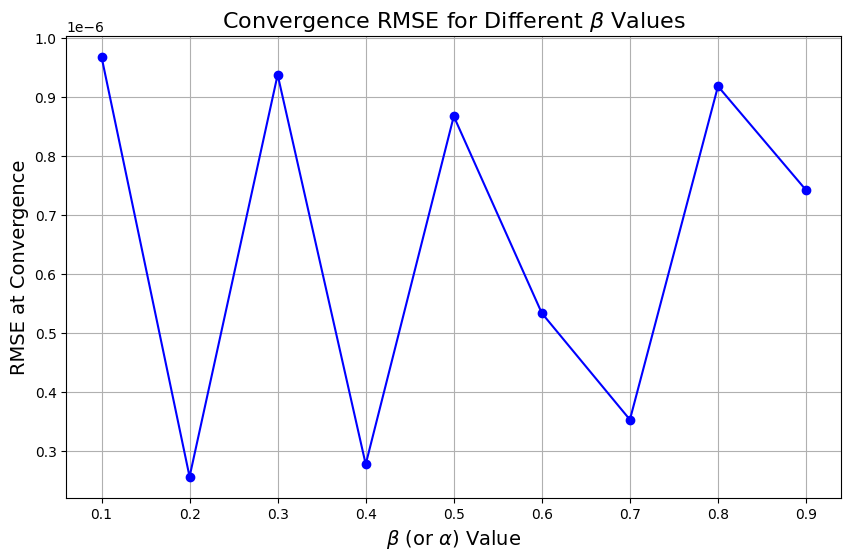

In [15]:
# Choose a user for the analysis
def rmse_for_beta(beta, G, personalization):
    """
    Compute the final RMSE for each beta value.

    Parameters:
    - beta: Damping factor for PageRank
    - G: Graph object
    - personalization: Personalization dictionary for PageRank

    Returns:
    - Final RMSE value at convergence.
    """
    # Get all RMSE values over iterations
    ppr, rmse_values = personalized_page_rank_with_rmse(G, personalization=personalization, alpha=beta)

    # Return the last RMSE value (final RMSE at convergence)
    return rmse_values[-1] if rmse_values else 0

# Choose a user for the analysis
user = sampled_users[0]
rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
personalization = {node: 1 if node in rated_movies else 0 for node in H_reduced}

# Compute RMSE for a range of beta (α) values
beta_values = np.linspace(0.1, 0.9, 9)
rmse_values = [rmse_for_beta(beta, H_reduced, personalization) for beta in beta_values]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(beta_values, rmse_values, marker='o', color='b')
plt.xlabel(r"$\beta$ (or $\alpha$) Value", fontsize=14)
plt.ylabel("RMSE at Convergence", fontsize=14)
plt.title(r"Convergence RMSE for Different $\beta$ Values", fontsize=16)
plt.grid(True)
plt.show()

Choosing Optimal β:
*   The optimal value of β is the one with the lowest RMSE.
*   If the RMSE decreases as β increases (toward 0.85 or 0.9), it suggests the user preference model is more influenced by the graph structure.
*   If the RMSE is minimized at a lower β (e.g., around 0.5), it indicates a stronger influence of the random jump component, possibly due to limited connectivity or sparse ratings.

**Justify your choice on the number of program iterations for convergence**

Convergence achieved after 25 iterations with RMSE: 0.000001


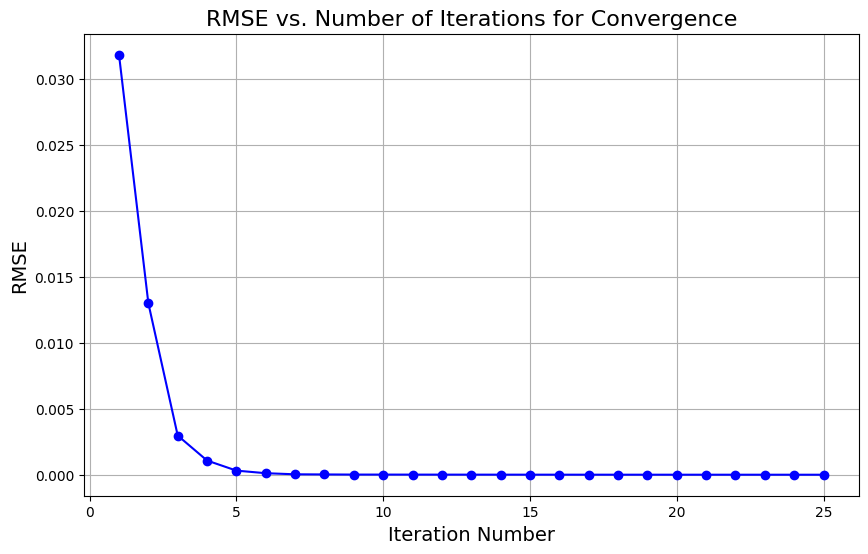

In [16]:
# Define a function to track RMSE across iterations
def personalized_page_rank_with_convergence_analysis(G, personalization, alpha, max_iter=100, tol=1e-6):
    n = len(G)
    ppr = {node: 1 / n for node in G}
    previous_ppr = ppr.copy()
    rmse_values = []

    for i in range(max_iter):
        # Update PageRank values using the formula
        teleport = (1 - alpha) / n
        ppr = {node: teleport + alpha * sum(previous_ppr[neighbor] / G.degree(neighbor)
                                            for neighbor in G.neighbors(node))
               for node in G}

        # Calculate RMSE for current iteration
        rmse = np.sqrt(sum((ppr[node] - previous_ppr[node]) ** 2 for node in G))
        rmse_values.append(rmse)

        # Check for convergence
        if rmse < tol:
            print(f"Convergence achieved after {i+1} iterations with RMSE: {rmse:.6f}")
            break

        previous_ppr = ppr.copy()

    return ppr, rmse_values

# Choose a user and compute Personalized PageRank
user = sampled_users[0]
rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
personalization = {node: 1 if node in rated_movies else 0 for node in H_reduced}

# Perform Personalized PageRank with analysis of RMSE
alpha = 0.85
max_iter = 100
ppr, rmse_values = personalized_page_rank_with_convergence_analysis(H_reduced, personalization, alpha, max_iter)

# Plot RMSE values over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rmse_values) + 1), rmse_values, marker='o', color='blue')
plt.xlabel('Iteration Number', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('RMSE vs. Number of Iterations for Convergence', fontsize=16)
plt.grid(True)
plt.show()

*   The RMSE plot shows a rapid decrease in error during the initial iterations, followed by a flattening curve as it approaches convergence.
*   The iteration where the RMSE flattens out indicates that additional iterations do not significantly change the PageRank values.
*   Setting max_iter = 10 would be a reasonable choice.




**Justify your choice of 'k'**

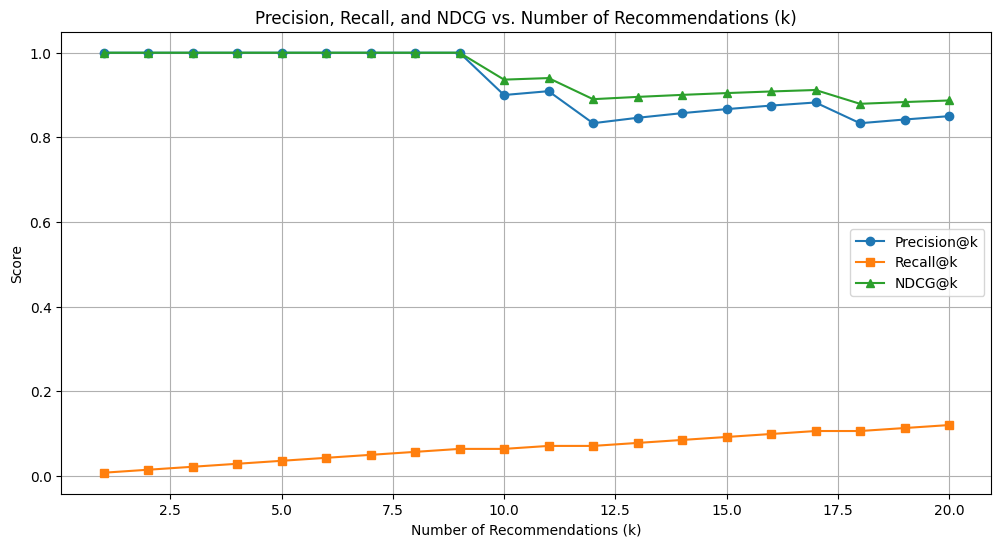

In [18]:
# Define functions for evaluation metrics
def precision_at_k(recommended, relevant, k):
    intersection = len(set(recommended[:k]) & set(relevant))
    return intersection / k

def recall_at_k(recommended, relevant, k):
    intersection = len(set(recommended[:k]) & set(relevant))
    return intersection / len(relevant) if len(relevant) > 0 else 0

def ndcg_at_k(recommended, relevant, k):
    dcg = sum([int(item in relevant) / np.log2(i + 2) for i, item in enumerate(recommended[:k])])
    idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(relevant)))])
    return dcg / idcg if idcg != 0 else 0

# Choose a user for the analysis
user = sampled_users[0]
rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
personalization = {node: 1 if node in rated_movies else 0 for node in H_reduced}
ppr = nx.pagerank(H_reduced, personalization=personalization, alpha=0.85)

# Generate recommended items sorted by Personalized PageRank scores
recommended_movies = sorted(ppr.keys(), key=lambda x: ppr[x], reverse=True)

# Range of k values to analyze
k_values = list(range(1, 21))
precision_values = []
recall_values = []
ndcg_values = []

# Compute metrics for each k
for k in k_values:
    precision = precision_at_k(recommended_movies, rated_movies, k)
    recall = recall_at_k(recommended_movies, rated_movies, k)
    ndcg = ndcg_at_k(recommended_movies, rated_movies, k)

    precision_values.append(precision)
    recall_values.append(recall)
    ndcg_values.append(ndcg)

# Plotting Precision, Recall, and NDCG vs. k
plt.figure(figsize=(12, 6))
plt.plot(k_values, precision_values, label="Precision@k", marker='o')
plt.plot(k_values, recall_values, label="Recall@k", marker='s')
plt.plot(k_values, ndcg_values, label="NDCG@k", marker='^')
plt.xlabel("Number of Recommendations (k)")
plt.ylabel("Score")
plt.title("Precision, Recall, and NDCG vs. Number of Recommendations (k)")
plt.legend()
plt.grid(True)
plt.show()

Precision@k:
*   Typically decreases as k increases because more items are included, some of which may not be relevant.
*   A sudden drop in precision might indicate that k is too high, and non-relevant items dilute the top recommendations.

Recall@k:
*   Increases as k increases because more relevant items are likely to be included.
*   If recall reaches a plateau (e.g., above 10), increasing k further might not be necessary as most relevant items are already included.

NDCG@k:
*   A balance between precision and ranking quality. It typically peaks at an optimal k and then stabilizes or slightly decreases as k increases.
*   The value of k where NDCG is maximized or stabilizes is often the most effective choice for the recommendation list length.

The optimal value of k is where NDCG stabilizes without a significant loss in precision. This k ensures that the user gets a reasonable number of high-quality recommendations without overwhelming them with non-relevant items.

**Bonus Points to Improve the Ranking**

**Incorporating Significance of Ratings in Ranking**

In [19]:
def get_top_k_recommendations_with_ratings(ppr, k, user_ratings):
    """
    Get top-k movie recommendations with enhanced ranking based on ratings.

    Parameters:
    - ppr: dict
        Dictionary of nodes with their personalized page rank as value.
    - k: int
        Number of recommendations.
    - user_ratings: dict
        Dictionary of movie ratings given by the user.

    Returns:
    - List of top-k movie recommendations with enhanced ranking.
    """
    # Weight PPR score by movie ratings (normalize ratings to range [0, 1])
    max_rating = max(user_ratings.values()) if user_ratings else 1
    enhanced_scores = {
        movie: ppr.get(movie, 0) * (user_ratings.get(movie, 0) / max_rating)
        for movie in ppr.keys()
        if G.nodes[movie]['type'] == 'movie'
    }

    # Sort movies by enhanced score
    sorted_movies = sorted(enhanced_scores.items(), key=lambda x: x[1], reverse=True)
    return [movie[0] for movie in sorted_movies[:k]]

# Choose a user for analysis
user = sampled_users[0]
rated_movies = df_data[df_data["user_id"] == user][["movie_id", "rating"]]
user_ratings = dict(zip(rated_movies["movie_id"], rated_movies["rating"]))
personalization = {node: 1 if node in user_ratings else 0 for node in H_reduced}

# Compute Personalized PageRank
alpha = 0.85
ppr = nx.pagerank(H_reduced, personalization=personalization, alpha=alpha)

# Generate top-k recommendations with enhanced ranking
k = 10
recommended_movies_with_ratings = get_top_k_recommendations_with_ratings(ppr, k, user_ratings)
print("Top-k Recommendations (Enhanced by Ratings):", recommended_movies_with_ratings)

Top-k Recommendations (Enhanced by Ratings): [474, 50, 655, 286, 127, 269, 506, 100, 23, 181]


**Incorporating Genre-based Personalization**

In [26]:
from collections import defaultdict

# Function to extract genres for a movie based on genre columns
def get_movie_genres(df_item, movie_id):
    movie_row = df_item[df_item['movie_id'] == movie_id]
    if movie_row.empty:
        return []

    genre_columns = [col for col in movie_row.columns if 'genre_' in col]
    genres = []
    for col in genre_columns:
        if movie_row[col].values[0] == 1:
            genre_id = int(col.split('_')[1])
            genre_name = df_genre[df_genre['genre_id'] == genre_id]['genre_name'].values[0]
            genres.append(genre_name)

    return genres

# Create graph and add movies, genres, and users
H_reduced = nx.Graph()

# Add movie nodes and connect to genre nodes
for _, row in df_item.iterrows():
    movie_id = row['movie_id']
    movie_genres = get_movie_genres(df_item, movie_id)

    # Add movie node and assign type as 'movie'
    H_reduced.add_node(movie_id, type='movie')

    # Add genre nodes and connect them to movie nodes
    for genre in movie_genres:
        if not H_reduced.has_node(genre):
            H_reduced.add_node(genre, type='genre')
        H_reduced.add_edge(movie_id, genre)
        H_reduced.add_edge(genre, movie_id)

# Add user nodes and connect to movie nodes based on ratings
for _, row in df_data.iterrows():
    user_id = row['user_id']
    movie_id = row['movie_id']

    # Add user node and assign type as 'user'
    if not H_reduced.has_node(user_id):
        H_reduced.add_node(user_id, type='user')

    # Add edge between user and movie
    H_reduced.add_edge(user_id, movie_id)
    H_reduced.add_edge(movie_id, user_id)

# Function to get personalized vector including genre affinity
def get_personalization_with_genre(user, user_ratings, user_genre_affinity, graph):
    personalization = {}

    # Personalization for rated movies
    for node in graph.nodes():
        if graph.nodes[node].get('type') == 'movie' and node in user_ratings:
            personalization[node] = user_ratings[node]

    # Personalization for genres based on user affinity
    for genre, score in user_genre_affinity[user].items():
        if genre in graph:
            personalization[genre] = score

    # Normalize the personalization vector
    total_score = sum(personalization.values()) if personalization else 1
    return {key: value / total_score for key, value in personalization.items()}

# Generate user ratings and genre affinities (example user)
user = 1  # Example user ID
user_ratings = df_data[df_data['user_id'] == user].set_index('movie_id')['rating'].to_dict()

# Create user-genre affinity based on movie ratings and genres
user_genre_affinity = defaultdict(lambda: defaultdict(int))

for _, row in df_data.iterrows():
    user = row['user_id']
    movie = row['movie_id']
    rating = row['rating']
    movie_genres = get_movie_genres(df_item, movie)

    for genre in movie_genres:
        user_genre_affinity[user][genre] += rating

# Normalize user-genre affinity
for user, genre_scores in user_genre_affinity.items():
    max_score = max(genre_scores.values()) if genre_scores else 1
    user_genre_affinity[user] = {genre: score / max_score for genre, score in genre_scores.items()}

# Generate personalized vector with genre-based preferences
personalization_with_genre = get_personalization_with_genre(user, user_ratings, user_genre_affinity, H_reduced)

# Compute Personalized PageRank with the enhanced personalization vector
alpha = 0.85
ppr_with_genre = nx.pagerank(H_reduced, personalization=personalization_with_genre, alpha=alpha)

# Generate top-k recommendations with enhanced ranking
k = 10
recommended_movies_with_genre = sorted(ppr_with_genre.items(), key=lambda x: x[1], reverse=True)[:k]
recommended_movie_ids = [movie[0] for movie in recommended_movies_with_genre]

print("Top-k Recommendations (Enhanced by Genre):", recommended_movie_ids)

Top-k Recommendations (Enhanced by Genre): [181, 13, 405, 1, 7, 234, 655, 50, 222, 269]
